# DATABASE SIGNATURE COMPARISON (UPSET PLOT)

This notebooks shows the code and resulting plot used to analyse the agreement between the different database signatures regarding ankyrin repeat annotations.

In [1]:
import pandas as pd
import retrieve_data_allsp
import importlib
import numpy as np
import upsetplot
import matplotlib.pyplot as plt

In [2]:
anks_all_sp = pd.read_csv("/cluster/gjb_lab/2394007/data_retrieval/all_anks_allsp.csv") # ALL ANKYRIN REVIEWED ANNOTATIONS

In [10]:
anks_all_sp.head()

,accession,end,length,repeat_id,source,start,repeat_length,taxonomy_id,species
0,A0A072VIM5,277,492,A0A072VIM5/248-277,Uniprot,248,30,3880,MEDTR
1,A0A072VIM5,307,492,A0A072VIM5/277-307,SM00248,277,31,3880,MEDTR
2,A0A072VIM5,307,492,A0A072VIM5/278-307,Uniprot,278,30,3880,MEDTR
3,A0A072VIM5,344,492,A0A072VIM5/312-344,PS50088,312,33,3880,MEDTR
4,A0A072VIM5,341,492,A0A072VIM5/312-341,SM00248,312,30,3880,MEDTR


In [3]:
anks_all_sp.source.value_counts()

Uniprot    7230
SM00248    6396
PS50088    4119
PR01415     792
PF00023     233
PF13606      55
Name: source, dtype: int64

In [4]:
anks_dict = retrieve_data_allsp.df_to_dict(anks_all_sp)

In [5]:
list(anks_dict["HUMAN"]["A0A0A6YYL3"].keys())[:5]

['PR01415', 'PS50088', 'SM00248', 'Uniprot']

In [6]:
jacc_t = {
    ('PS50088','SM00248') : 0.6, ('PS50088','Uniprot') : 0.6, ('PS50088','PR01415') : 0.25, 
    ('PS50088','PF13606') : 0.75, ('PS50088','PF00023') : 0.5, ('SM00248','Uniprot') : 0.45,
    ('SM00248','PR01415') : 0.2, ('SM00248','PF13606') : 0.85, ('SM00248','PF00023') : 0.6,
    ('Uniprot','PR01415') : 0.2, ('Uniprot','PF13606') : 0.85, ('Uniprot','PF00023') : 0.6,
    ('PR01415','PF13606') : 0.4, ('PR01415','PF00023') : 0.3, ('PF13606','PF00023') : 0.5
} # JACCARD INDEX THRESHOLDS FOR ALL POSSIBLE DATABASE COMPARISONS

In [7]:
def get_overlap_all_dbs(df):
    df_dict = retrieve_data_allsp.df_to_dict(df)
    overlaps = []
    specs = list(df_dict.keys())
    for spec in specs:
        spec_dict = df_dict[spec]
        accs = list(spec_dict.keys())
        for acc in accs:
            acc_dict = spec_dict[acc]
            acc_sigs = list(acc_dict.keys())
            for ref_sig_idx, ref_sig in enumerate(acc_sigs):
                ref_dict = acc_dict[ref_sig]
                ref_reps = list(ref_dict.keys())
                rep_res = [ref_sig,]
                for ref_rep in ref_reps:
                    for sample_sig_idx, sample_sig in enumerate(acc_sigs[ref_sig_idx+1:]):
                        sample_dict = acc_dict[sample_sig]
                        sample_reps = list(sample_dict.keys())
                        for sample_rep in sample_reps:
                            j = retrieve_data_allsp.jaccard(ref_dict[ref_rep],sample_dict[sample_rep])
                            if (ref_sig, sample_sig) in jacc_t:
                                t = jacc_t[(ref_sig, sample_sig)]
                            else:
                                t = jacc_t[(sample_sig,ref_sig)]
                            if j >= t:
                                rep_res.append(sample_sig)
                                del(df_dict[spec][acc][sample_sig][sample_rep])
                    overlaps.append(set(rep_res))
    return overlaps

def get_unique(overlap_list):
    unique_combs = []
    for el in overlap_list:
        if el not in unique_combs:
            unique_combs.append(el)
    return unique_combs

def get_comb_freq(overlaps, unique_combs):
    tup_list = [tuple(el) for el in unique_combs]
    db_overlap = {}
    for el in tup_list:
        db_overlap[el] = overlaps.count(set(el))
    return db_overlap

def get_upset_input(db_overlap):
    ll = []
    data = []
    for k, v in db_overlap.items():
        ll.append(list(k))
        data.append(v)
    return ll, data

In [19]:
anks_annotations

PF00023  PF13606  PR01415  PS50088  SM00248  Uniprot
False    False    False    True     False    False         4
                  True     True     True     True        717
                  False    True     True     True       3124
                           False    True     True       2149
True     False    True     True     True     True         38
False    False    False    False    False    True        966
                  True     False    True     True         28
True     False    False    True     True     True        167
False    False    False    False    True     False        98
                           True     False    True         36
True     False    False    False    True     True         23
False    True     False    True     True     False         2
                                    False    True          1
                                    True     True         34
                  True     True     True     True         13
True     False    False    True 

In [8]:
reps = get_overlap_all_dbs(anks_all_sp) # CALCUALTES ANK ANNOTATION OVERLAP BETWEEN ALL SIGNATURES
reps_un = get_unique(reps) # RETURNS UNIQUE DATABASE OVERLAP COMBINATIONS
comb_dict = get_comb_freq(reps, reps_un) # CALCUALTES FREQUENCY OF EACH COMBINATION
ll, data = get_upset_input(comb_dict) # GENERATES NECESSARY INPUT FOR UPSETPLOT LIBRARY
anks_annotations = upsetplot.from_memberships(ll, data)

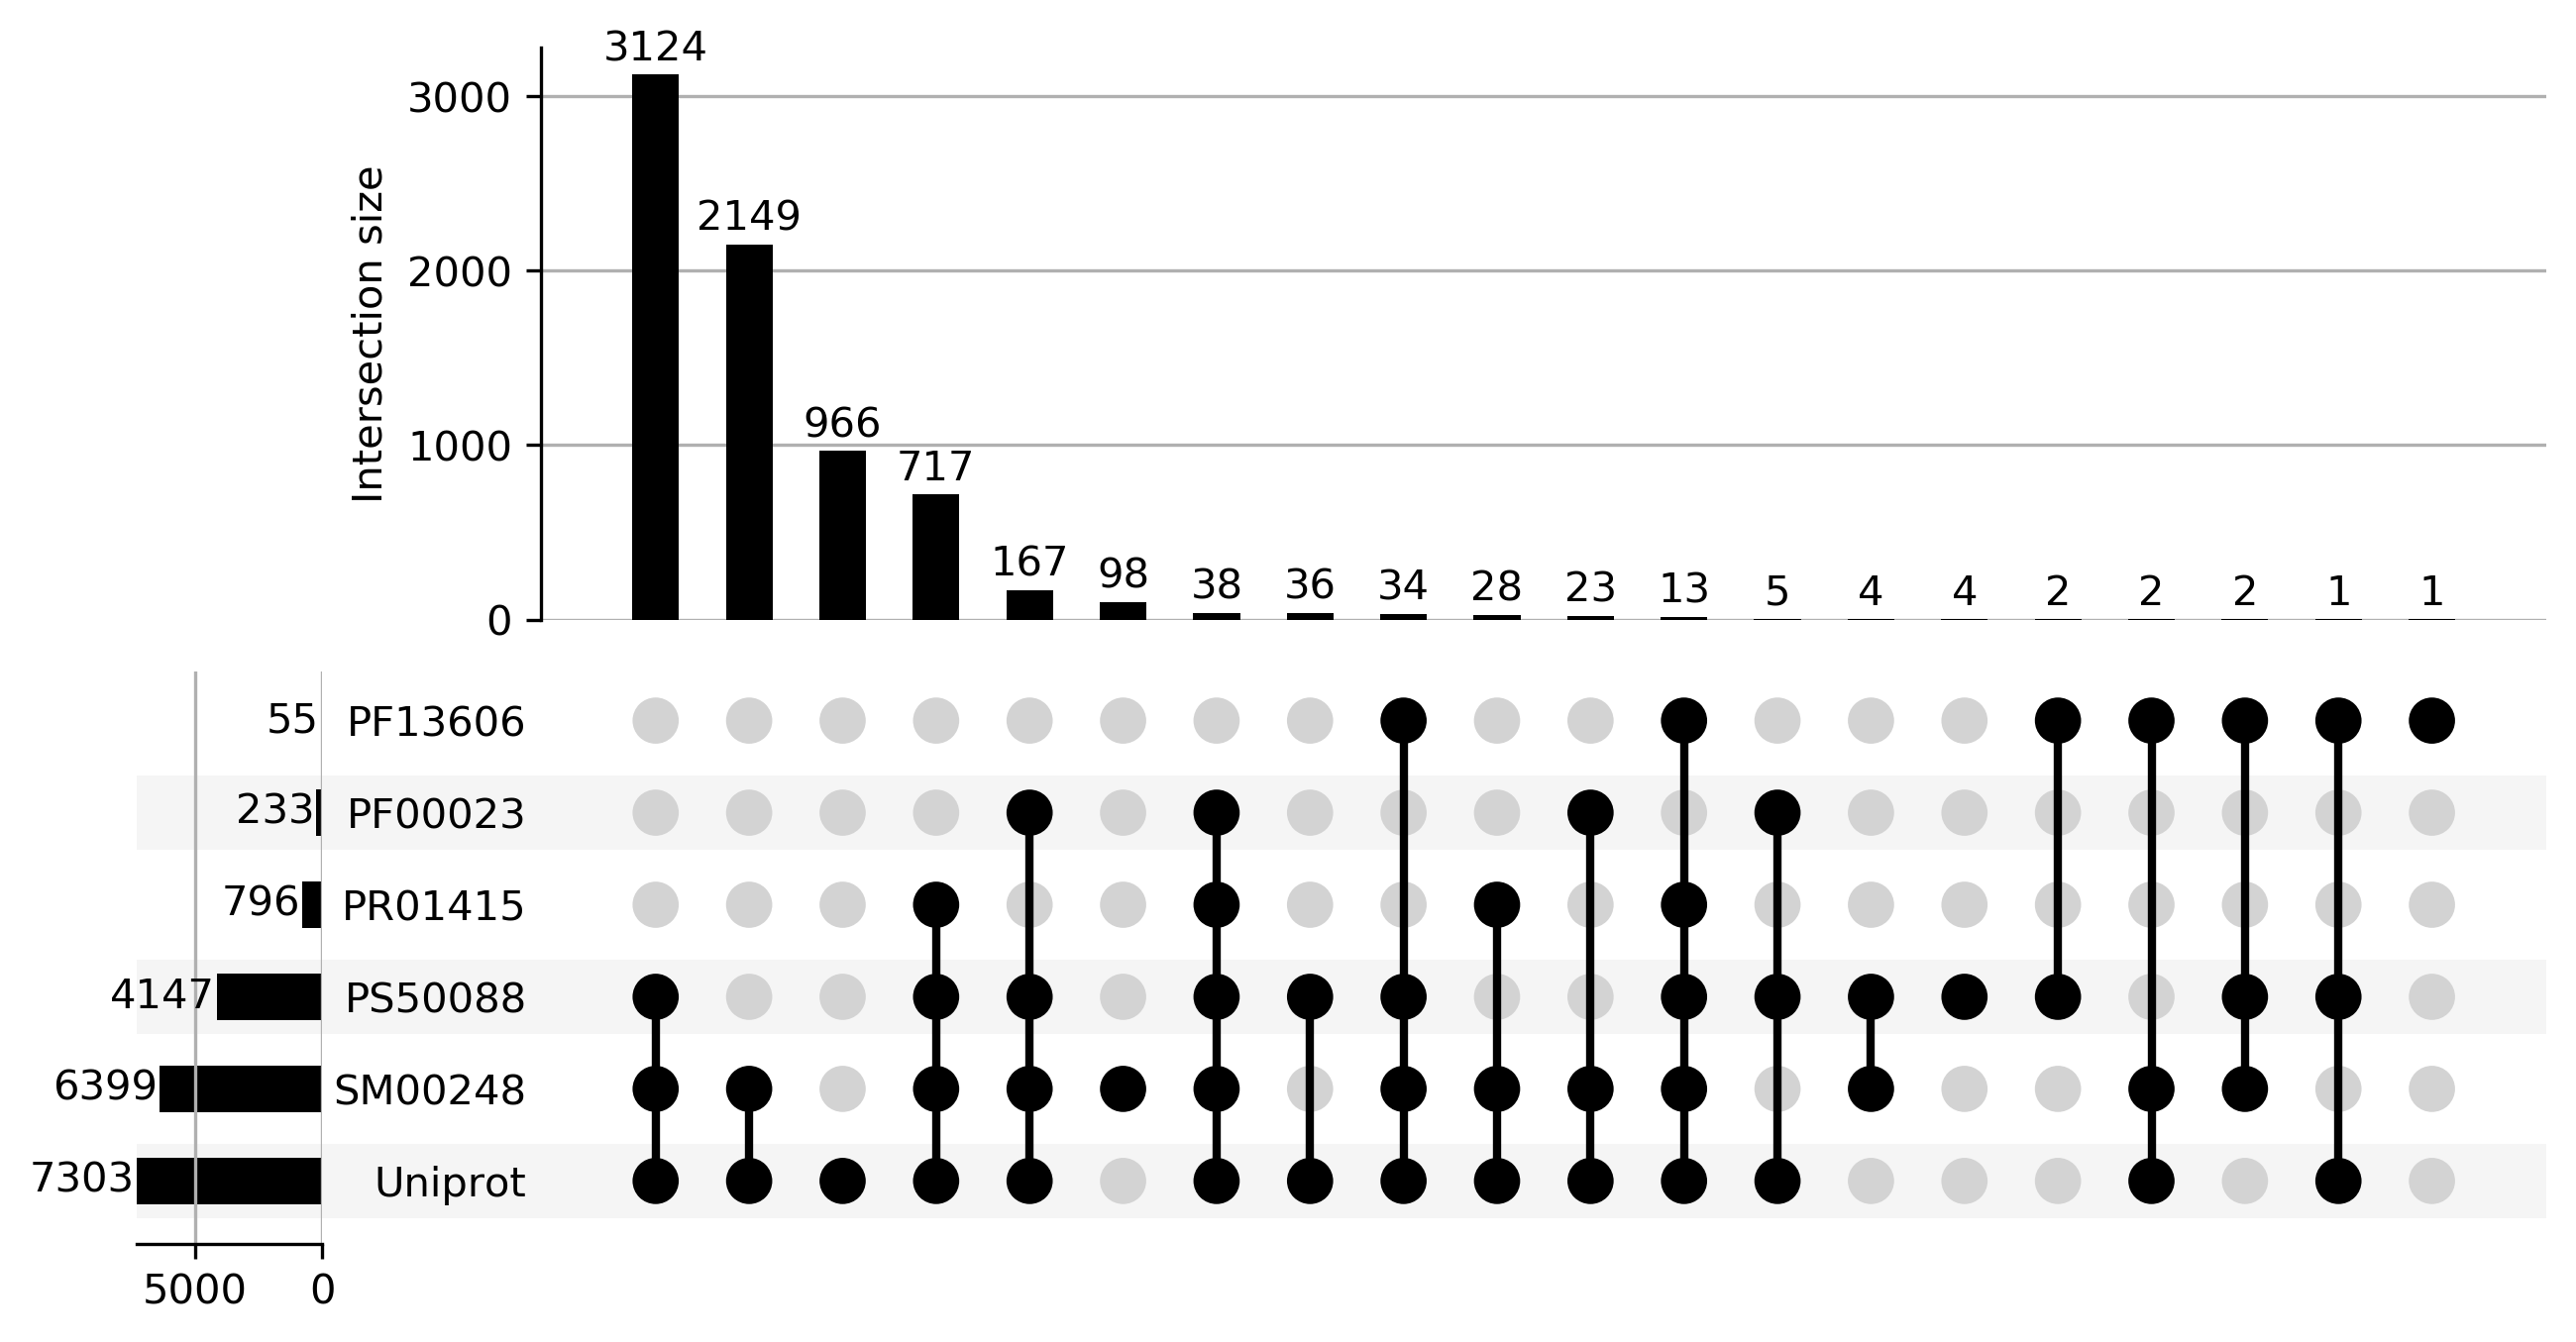

In [9]:
fig1 = plt.figure(figsize=(70,60), dpi = 300)
upsetplot.plot(anks_annotations, fig1, sort_by='cardinality',show_counts='%d')
#plt.savefig('/homes/2394007/figures/def/upset_allsp_new.png')
plt.show()